# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1320s2"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1582, 32, 20, 3)
(1582, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
396/396 [==============================] - 4s 9ms/step - loss: 2.2060 - accuracy: 0.3084
Epoch 2/500
396/396 [==============================] - 4s 9ms/step - loss: 1.4547 - accuracy: 0.5454
Epoch 3/500
396/396 [==============================] - 4s 9ms/step - loss: 1.0399 - accuracy: 0.6740
Epoch 4/500
396/396 [==============================] - 4s 10ms/step - loss: 0.7859 - accuracy: 0.7539
Epoch 5/500
396/396 [==============================] - 4s 10ms/step - loss: 0.6694 - accuracy: 0.8060 0s - loss:
Epoch 6/500
396/396 [==============================] - 4s 10ms/step - loss: 0.6055 - accuracy: 0.8158
Epoch 7/500
396/396 [==============================] - 4s 10ms/step - loss: 0.5277 - accuracy: 0.8366
Epoch 8/500
396/396 [==============================] - 4s 10ms/step - loss: 0.4293 - accuracy: 0.8640
Epoch 9/500
396/396 [==============================] - 4s 11ms/step - loss: 0.4308 - accuracy: 0.8623
Epoch 10/500
396/396 [==============================] - 4s 10ms/step - los

396/396 [==============================] - 4s 9ms/step - loss: 0.0666 - accuracy: 0.9784
Epoch 79/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0739 - accuracy: 0.9809
Epoch 80/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0695 - accuracy: 0.9683
Epoch 81/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0703 - accuracy: 0.9809
Epoch 82/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0817 - accuracy: 0.9750
Epoch 83/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0735 - accuracy: 0.9819
Epoch 84/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0698 - accuracy: 0.9821
Epoch 85/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0735 - accuracy: 0.9772
Epoch 86/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0660 - accuracy: 0.9786
Epoch 87/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0615 - accuracy: 

Epoch 156/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0302 - accuracy: 0.9910
Epoch 157/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0487 - accuracy: 0.9825 1s
Epoch 158/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0564 - accuracy: 0.9832
Epoch 159/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0539 - accuracy: 0.9880 0s - loss: 0.0544 
Epoch 160/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0441 - accuracy: 0.9881
Epoch 161/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0377 - accuracy: 0.9909
Epoch 162/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0294 - accuracy: 0.9927
Epoch 163/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0263 - accuracy: 0.9861 0s - los
Epoch 164/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0577 - accuracy: 0.9865
Epoch 165/500
396/396 [==========

396/396 [==============================] - 4s 10ms/step - loss: 0.0198 - accuracy: 0.9940
Epoch 254/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0318 - accuracy: 0.9923
Epoch 255/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0722 - accuracy: 0.9862
Epoch 256/500
396/396 [==============================] - 5s 11ms/step - loss: 0.0173 - accuracy: 0.9942
Epoch 257/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0120 - accuracy: 0.9964 1s - loss: 0.0084 - accuracy:  - ETA: 0s - l
Epoch 258/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0273 - accuracy: 0.9873
Epoch 259/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0158 - accuracy: 0.9933 0s - loss: 0.0141 
Epoch 260/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0222 - accuracy: 0.9939
Epoch 261/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0391 - accuracy: 0.9908
Epoch 262/500


396/396 [==============================] - 4s 10ms/step - loss: 0.0457 - accuracy: 0.9954
Epoch 378/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0205 - accuracy: 0.9958: 0s - loss: 0.019
Epoch 379/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0437 - accuracy: 0.9905
Epoch 380/500
396/396 [==============================] - 4s 9ms/step - loss: 0.0312 - accuracy: 0.9931
Epoch 381/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0068 - accuracy: 0.9976 0s - loss: 0.0056 - 
Epoch 382/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0093 - accuracy: 0.9974
Epoch 383/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0223 - accuracy: 0.9940
Epoch 384/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0350 - accuracy: 0.9930
Epoch 385/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0200 - accuracy: 0.9938A
Epoch 386/500
396/396 [=================

396/396 [==============================] - 5s 11ms/step - loss: 0.0233 - accuracy: 0.9943 0s - los
Epoch 461/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0087 - accuracy: 0.9959
Epoch 462/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0163 - accuracy: 0.9931
Epoch 463/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0356 - accuracy: 0.9920
Epoch 464/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0138 - accuracy: 0.9944
Epoch 465/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0213 - accuracy: 0.9926
Epoch 466/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0205 - accuracy: 0.9976
Epoch 467/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0068 - accuracy: 0.9989 1s - loss: 0.0 - ETA: 0s - loss: 0.005
Epoch 468/500
396/396 [==============================] - 4s 11ms/step - loss: 0.0215 - accuracy: 0.9953
Epoch 469/500
396/396 [=======

### Learing result
 
* Visualization of the training and validation results

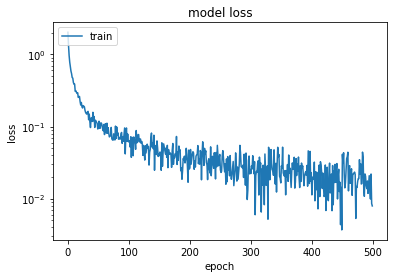

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_1_ht5_20210627-220703.jpg 0 1


ziffer_sortiert_resize\3_0_ht6_20210702-055135.jpg 3 9


ziffer_sortiert_resize\3_1_ht4_20210627-124615.jpg 3 4


ziffer_sortiert_resize\3_6_ht6_20210702-044832.jpg 3 9


ziffer_sortiert_resize\5_3_dig4_20210721-144728.jpg 5 9


ziffer_sortiert_resize\5_3_dig6_20210723-134707.jpg 5 9


ziffer_sortiert_resize\6_D8_2020-08-19_20-22-27.jpg 6 -1


ziffer_sortiert_resize\7_D7_2020-08-20_15-23-28.jpg 7 -1


ziffer_sortiert_resize\8_3_dig4_20210725-094630.jpg 8 -1


ziffer_sortiert_resize\8_D7_2020-08-14_00-01-25.jpg 8 9


ziffer_sortiert_resize\8_D8_2020-08-20_15-23-28.jpg 8 9


ziffer_sortiert_resize\NaN_0_ht6_20210628-182853.jpg -1 9


ziffer_sortiert_resize\NaN_4_ht7_20210701-112725.jpg -1 4


ziffer_sortiert_resize\NaN_5_dig6_20210629-114809.jpg -1 9


ziffer_sortiert_resize\NaN_Ziffer_NaN_1250.jpg -1 9


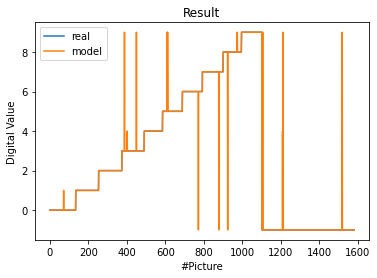

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpid40mq__\assets


356508

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp2mc527qd\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp2mc527qd\assets


dig1320s2q.tflite


98416

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.